## Project 1: A horserace of asset allocations

Imagine you were sitting on the board of some large investor and you would like to decide on an approach for your strategic asset allocation. The following strategies might cross your mind: 

* Mean Variance approach: 
    * Idea: You maximize the sharpe ratio of your portfolio by assuming mean returns, volatilities and correlations will stay roughly the same over the long run.
    * Pro: Theorically sound
    * Con: You have to estimate the above-mentioned variables, and assume them to remain stable.  
* Minimum Variance:
    * Idea: You minimize the volatlity of your portfolio by assuming volatilities and correlations will stay roughly the same over the long run.
    * Pro: Less volatility of the above and theoretically efficient if there is no risk-free rate. Moreover, you do not need to estimate mean returns. 
    * Con: You have to estimate 2 of the above-mentioned variables.
* Risk-Parity: 
    * Idea: You assume that certain assets come with different risk factors, which you would like to be exposed to equally, so that you do not take bets on the development of those risk factors. You keep the risk exposure of your portfolio in *parity* by weighting the assets according to the inverse of their variance ($1/Var(R_i)$)
    * Pro: You are - according to the theory - *truely diversified* because you believe the underlying risk-factors are uncorrelated.  
    * Con: You have to assume risk factors are uncorrelated and still rely on assumptions about the variances. 
* Equally Weighted:
    * Idea: You keep it simple and just allocate all assets to the same degree, thereby selling winners and buying losers on rebalancing.
    * Pro: Very simple and especially successful during high volatility without strong trends.
    * Con: If trends in markets persist over rebalancings and or volatility is low. The strategy will sell what works and buy what doesn't.  

(This table is loosely on [Andrew Ang's book on factor investing](https://www.amazon.de/Asset-Management-Systematic-Investing-Association-ebook/dp/B00KW69ORW))

Luckily, because you are such a long term investor. You have exactly one year to decide what to do. And you decide to give all of these strategies a paper track record during the time. Whoever wins the *horserace* will get your money - fair game. 

**To the data!**

In [446]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import quandl
quandl.ApiConfig.api_key = "Jq_aYr5vETsGDgmPVVsA"

In [447]:
Euro_Stoxx50 = quandl.get("CHRIS/EUREX_FESX1")
E_minis500 = quandl.get("CHRIS/CME_ES2")
Gold = quandl.get("CHRIS/CME_GC3")
treasury10y = quandl.get("CHRIS/CME_TY1")
names=["EuroStoxx50","S&P500EMinis","Gold","Treasury10y"]
futures = pd.concat([Euro_Stoxx50["Settle"],E_minis500["Settle"],Gold["Settle"],treasury10y["Settle"]],axis=1)
futures.columns = names
futures.tail()

,EuroStoxx50,S&P500EMinis,Gold,Treasury10y
Date,,,,
2020-02-03,3654.000,3245.500,1582.400,131.578
2020-02-04,3722.000,3299.750,1555.500,130.891
2020-02-05,3770.000,3335.250,1562.800,130.547
2020-02-06,3799.000,3345.500,1570.000,130.562
2020-02-07,3793.000,3325.500,1573.400,131.078


By downloading the continouos futures data from Quandl, we get accurate price data for relevant asset classes which we can use for our global portfolio. We get some of the core components of most asset allocations. DM-Equities, Treasuries and Gold. Let's plot this, shall we?

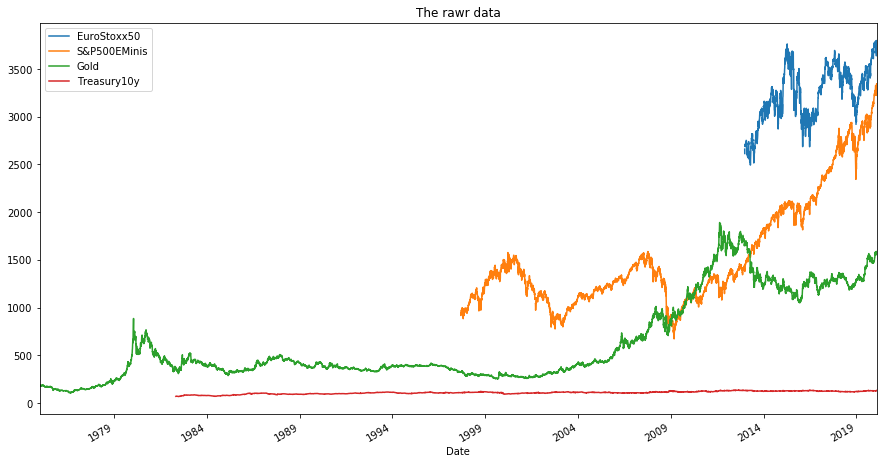

In [448]:
futures.plot(figsize = (15,8),title="The rawr data");

It is fairly obvious, that we still need to do a little bit of data tyding. First of all, we will only consider time periods for which we have good data. According to the plot, the last series to start is the one on of the EuroStoxx 50, sometime around 2012. Secondly, I will also index the data to that date, so that differences levels do not skew what we see. 

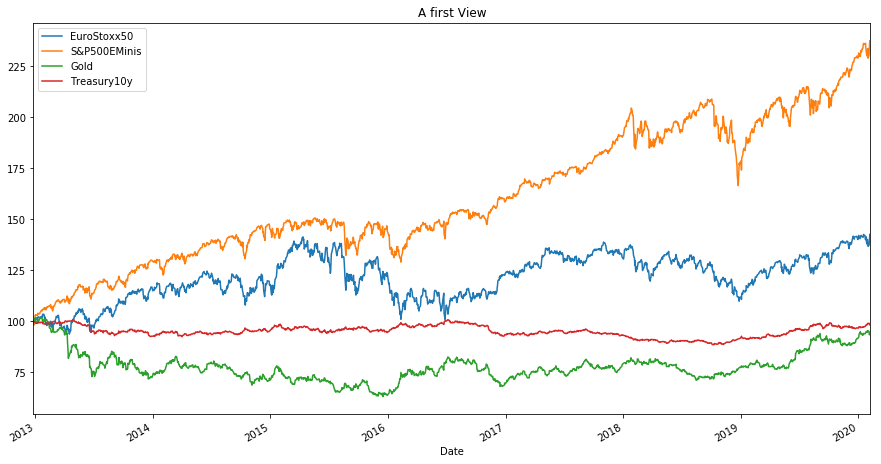

In [449]:
futures = futures.dropna()
futures = (futures/futures.iloc[0])*100
futures.plot(figsize = (15,8),title="A first View");

This gives us a nicely behaved plot in which we can interrpet the final row as percentage increase since the beginning of our data in 2013. Where are we now?

In [450]:
(round(futures.tail(1)-100,1))

,EuroStoxx50,S&P500EMinis,Gold,Treasury10y
Date,,,,
2020-02-07,42.500,136.300,-5.600,-1.400


### Data wrangling 
Since we finally have somewhat useful data to solve our portfolio construction problem, lets see what we need to get out of the data to find our portfolios: 
* The mean returns
* The variance-covariance-matrix

For convenience, we will take the log returns of the daily data and use that for the annualized mean returns ($average*252$) and our annualized (co-)variances ($variance*252$). We also only include data up until end of 2019, so that we do not optimize our portfolios with data from the time we want to test the portfolios.

In [451]:
futures_old = futures.loc[:"2019-12-31",]
futures_old_log = np.log(futures_old/futures_old.shift(1)).dropna()
mean_returns = np.array((futures_old_log.mean()*252))
var_covar = np.mat(futures_old_log.cov()*252)
std_dev = np.diagonal(var_covar)**0.5

Let's look take a look at mean returns and variances: 

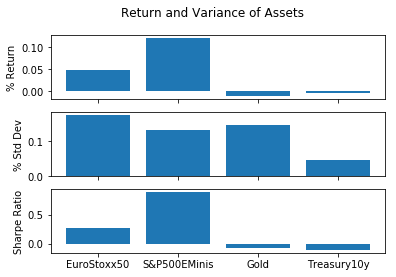

In [452]:
# Make a fake dataset:
y_pos = range(0,len(mean_returns))
fig, axs = plt.subplots(3,sharex=True)
fig.suptitle('Return and Variance of Assets')
axs[0].bar(y_pos, mean_returns)
axs[0].label_outer()
axs[0].set(ylabel='% Return')
axs[1].bar(y_pos, std_dev)
axs[1].set(ylabel='% Std Dev')
axs[2].bar(y_pos, mean_returns/std_dev)
axs[2].set(ylabel='Sharpe Ratio')
#axs[2].set_ylim([0,1.5])
#axs[2].set_yticks([0,0.4,0.8],minor = False)
plt.xticks(y_pos, names);

In [453]:
print("Precise Sharpe Ratios of the Assets are as follows", (mean_returns/std_dev))

Precise Sharpe Ratios of the Assets are as follows [ 0.27794717  0.90166159 -0.08348633 -0.10921821]


Next, lets look at the Correlation matrix: 

In [474]:
futures_old_log.corr()

,EuroStoxx50,S&P500EMinis,Gold,Treasury10y
EuroStoxx50,1.000,0.565,-0.204,-0.325
S&P500EMinis,0.565,1.000,-0.080,-0.301
Gold,-0.204,-0.080,1.000,0.363
Treasury10y,-0.325,-0.301,0.363,1.000


### Portfolio Functions
After all this data wrangling. Let's finally construct the portfolios. Please see below for the approaches we are using: 
* Mean Variance approach: We minimize the variance for portfolios with a given return that is above the return of the min var portfolio and below the return of the maximum return portfolio. 
* Minimum Variance: We minimize the expression for the variance of the portfolio which is simply $weights^T*VarCovar*weights$
* Risk-Parity: We scale the weights of the assets by the ivnerse of their variance. ($1/Var(R_i)$)
* Equally Weighted: $1/N$




To find the properties of our portfolios, we will need a couple of helper functions. Below, we include functions to compute the Variance, Return and the negative of the Sharpe Ratio of our Portfolios. We compute the negative because the scipy optimizer finds the minimum of the function we put into it. Additionally, I include functions which allow us to compute optimal portfolios by brute force, generating random weights and seeing what would have worked best in the past. The last of our functions relies on the others to do just this. Moreover, this will also give us a nice looking efficient frontier, which we plot below 

In [455]:
#Helper functions for optimization
def port_var(weights,var_mat):
    """
    Takes weights vector and Var-Covar Matrix to compute variance. 
    """
    weights = np.mat(weights).T #This is a usual vector with n rows and 1 column
    varcovar = np.mat(var_mat) #This is a n*n matrix
    port_var = weights.T*varcovar*weights #This will return a scalar
    return np.asscalar(port_var)

def port_ret(weights,returns):
    """
    Takes weights vector and mean returns to compute portfolio returns. 
    """
    port_ret = np.asscalar(np.mat(returns)*np.mat(weights).T)
    return port_ret

def min_var(weights):
    min_var = port_var(weights,var_covar)
    return min_var

def neg_sr(weights):
    """
    Takes weights vector and Var-Covar Matrix to compute variance. 
    """
    sr = (port_ret(weights,mean_returns)/port_var(weights,var_covar))
    return sr*-1

# Contraints: We assume that the portfolio is fully invested at all times
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

def random_weights(k):
    '''
    This function creates n number of weights that add up to 1
    '''
    randoms = np.array(random.sample(population = range(0,100),k=k))
    random_w = randoms/sum(randoms)
    return np.array(random_w)

def efficient_frontier(n,var_mat,returns):
    '''
    This function will take the random_weights function and the port_var function, a variance covariance matrix and the mean returns of our assets to return a dataframe with weights,portfolio std dev, returns and sharpe ratio 
    '''
    efficient_frontier = np.empty([n,7])
    for i in range(n):
        efficient_frontier[i,0:4]= random_weights(4)
        efficient_frontier[i,4]= port_var(efficient_frontier[i,0:4],var_covar)**0.5
        efficient_frontier[i,5]= port_ret(efficient_frontier[i,0:4],mean_returns)
        efficient_frontier[i,6]= efficient_frontier[i,5]/ efficient_frontier[i,4]
    
    efficient_frontier = pd.DataFrame(efficient_frontier, columns = ["EuroStoxx50","S&P500EMinis","Gold","Treasury10y","Port_Std","Port_Ret","Sharpe"],index=range(1,n+1))
    efficient_frontier = efficient_frontier.sort_values(by="Sharpe")
    
    return efficient_frontier

With these helper functions, we can now compute the standard minimum variance weights. 

In [456]:
# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

# 0-1 bounds for each weight: No shortselling!
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))
equal_weighted = [0.25,0.25,0.25,0.25]

min_var_weights = minimize(min_var,equal_weighted,method='SLSQP',bounds=bounds,constraints=cons).x
print(min_var_weights)

[  4.74872811e-02   1.38267095e-01   6.93889390e-18   8.14245624e-01]


Having the weights of the min-var portfolio. We can now compute its standard deviation and return with our helper function above. 

In [457]:
std_dev_min_var = (port_var(min_var_weights,var_covar))**0.5
return_min_var = port_ret(min_var_weights,mean_returns)
sharpe_min_var = round(return_min_var/std_dev_min_var,2)
print(round(std_dev_min_var,4),"std dev")
print(round(return_min_var,4),"return")
print(sharpe_min_var,"Sharpe")

0.0368 std dev
0.0149 return
0.41 Sharpe


Let's optimize the sharpe ratio next:

In [458]:
max_sr_weights = minimize(neg_sr,equal_weighted,method='SLSQP',bounds=bounds,constraints=cons).x
std_dev_max_sr = port_var(max_sr_weights,var_covar)**0.5
return_max_sr = port_ret(max_sr_weights,mean_returns)
sharpe_max_sr = round(return_max_sr/std_dev_max_sr,4)
print(round(std_dev_max_sr,4),"std dev")
print(round(return_max_sr,4),"return")
print(sharpe_max_sr,"Sharpe")

0.0444 std dev
0.0348 return
0.7829 Sharpe


Let's look at the portfolios of the Min-Var Portfolio and the best possbible portfolio in comparison: 

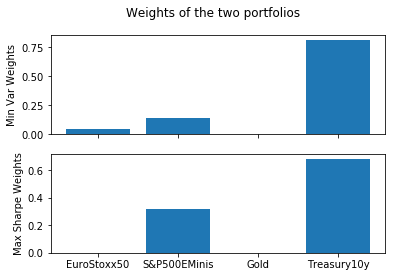

In [459]:
y_pos = range(0,len(mean_returns))
fig, axs = plt.subplots(2,sharex=True)
fig.suptitle('Weights of the two portfolios')
axs[0].bar(y_pos, min_var_weights)
axs[0].label_outer()
axs[0].set(ylabel='Min Var Weights')
axs[1].bar(y_pos, max_sr_weights)
axs[1].set(ylabel='Max Sharpe Weights')
plt.xticks(y_pos, names);

This actually gives a good idea of why relying on historical variances (and means in the latter case) is so useless in practise. Both portfolios are simply unbalanced. The strong negative correlation of treasuries and the S&P 500 in our example simply dominates both portfolios (see correlation matrix above). 

However, what I wonder about is the fact that the S&P 500 on its own has a sharpe ratio slightly above the one that we get from our optimization. Which shouldn't be the case as I see it. On the other hand, the methodoly applied is sound so it could be that it's due to rounding errors or a weak optimizer. 

Anyways, given this observation, lets try and find the full efficient frontier. How do we do this?
1. Create random portfolios of the four assets
2. Calculate their risk and returns
3. Plot it. 

In [460]:
#Random portfolio weights: 
random.seed(1994)
n = 10000
efficient_frontier_df = efficient_frontier(n = n, var_mat = var_covar, returns = mean_returns)

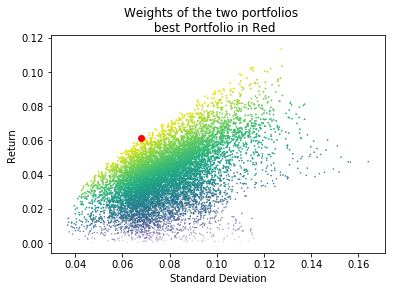

In [461]:
#efficient_frontier_df
text = round(efficient_frontier_df["Sharpe"].max(),2)
fig, ax = plt.subplots()
fig.suptitle('Weights of the two portfolios \n best Portfolio in Red')
ax.scatter(
    x = efficient_frontier_df["Port_Std"],
    y = efficient_frontier_df["Port_Ret"],
    s = efficient_frontier_df["Sharpe"],
    c = efficient_frontier_df["Sharpe"])
ax.scatter(
    x = efficient_frontier_df["Port_Std"].tail(1),
    y = efficient_frontier_df["Port_Ret"].tail(1),
    c = "red");
ax.set(ylabel='Return')
ax.set(xlabel='Standard Deviation');

In [462]:
efficient_frontier_df["Sharpe"].max()

0.90842217408488923

The efficient frontier we plotted above gives a good idea of opportunity sets available to us. However, strangely, it also shows that the maximum sharpe ratio achievable is far above our original optimization. Indeed it is 0.92 and not 0.78 as above.

Lets look at the last two portfolios and see how they fared. 

In [463]:
#Start with the equal weighted portfolio:
std_dev_equal = port_var(equal_weighted,var_covar)**0.5
return_equal = port_ret(equal_weighted,mean_returns)
sharpe_equal = return_equal/std_dev_equal

#... and continue with the risk parity portfolio
riskp_weights = (1/variances)/sum(1/variances)
std_dev_riskp = port_var(riskp_weights,var_covar)**0.5
return_riskp = port_ret(riskp_weights,mean_returns)
sharpe_riskp = return_riskp/std_dev_riskp

Lets collect all our data in a single Table to see how they fared: 

In [464]:
port_data=np.mat([[min_var_weights,std_dev_min_var,return_min_var,sharpe_min_var],
             [max_sr_weights,std_dev_max_sr,return_max_sr,sharpe_max_sr],
             [equal_weighted,std_dev_equal,return_equal,sharpe_equal],
             [riskp_weights,std_dev_riskp,return_riskp,sharpe_riskp]
            ])
port_indexes=["MinVar","MaxSROptim","Equal","RiskParity"]
port_df = pd.DataFrame(port_data,columns=["Weights","Port_Std","Port_Ret","Sharpe"],index=port_indexes)
df2 = pd.DataFrame(port_df['Weights'].values.tolist(), columns=names,index=port_indexes)
port_df = pd.merge(df2,port_df,left_index=True, right_index=True).drop("Weights",axis=1)
del df2
port_df = port_df.append(efficient_frontier_df.tail(1))
port_df.index = port_indexes+["BestRand"]
port_df

,EuroStoxx50,S&P500EMinis,Gold,Treasury10y,Port_Std,Port_Ret,Sharpe
MinVar,0.047,0.138,0.000,0.814,0.037,0.015,0.410
MaxSROptim,0.000,0.317,0.000,0.683,0.044,0.035,0.783
Equal,0.250,0.250,0.250,0.250,0.071,0.038,0.532
RiskParity,0.136,0.179,0.161,0.524,0.048,0.024,0.491
BestRand,0.000,0.531,0.013,0.456,0.068,0.062,0.908


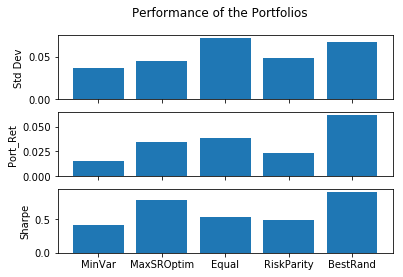

In [465]:
y_pos1 = range(0,len(port_df.index))
fig, axs = plt.subplots(3,sharex=True)
fig.suptitle('Performance of the Portfolios')
axs[0].bar(y_pos1, port_df["Port_Std"])
axs[0].label_outer()
axs[0].set(ylabel='Std Dev')
axs[1].bar(y_pos1, port_df["Port_Ret"])
axs[1].set(ylabel='Port_Ret')
axs[2].bar(y_pos1, port_df["Sharpe"])
axs[2].set(ylabel='Sharpe')
plt.xticks(y_pos1, port_df.index);

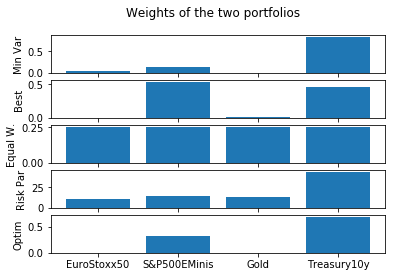

In [466]:
random_max_sr_weights = efficient_frontier_df.loc[efficient_frontier_df["Sharpe"].idxmax()][0:4]
y_pos = range(0,len(mean_returns))
fig, axs = plt.subplots(5,sharex=True)
fig.suptitle('Weights of the two portfolios')
axs[0].bar(y_pos, min_var_weights)
axs[0].label_outer()
axs[0].set(ylabel='Min Var')
axs[1].bar(y_pos, random_max_sr_weights)
axs[1].set(ylabel="Best")
axs[2].bar(y_pos, equal_weighted)
axs[2].set(ylabel="Equal W.")
axs[3].bar(y_pos, riskp_weighted)
axs[3].set(ylabel="Risk Par")
axs[4].bar(y_pos, max_sr_weights)
axs[4].set(ylabel='Optim')
plt.xticks(y_pos, names);

## Conclusions from historic data: 

Looking at the above plots the characteristics of each of the portfolios becomes evident: 

* Mean Variance approach: To no ones surprise our mean-variance portfolios is the best one since we have chosen the ideal weights ex-post. 
* Minimum Variance: Our minimum variance portfolio is basically just treasuries and has indeed the lowest variance. Again no surprise here.
* Risk-Parity: A risk parity portfolio is also heavily invested into treasuries, which is exactly how risk parity is often used in practise. It was also superior to our min var portfolio, but fared worse than the equal weighted portfolio.
* Equally Weighted: Our $1/N$ portfolio fared relatively well during the time. However, its large allocation to european stocks which did absolutely nothing in terms of generating return or diversifying the portfolio was probably not idea. 

In conclusion, for the last five years, a simple 60-40 portfolio of S&P500 and treasuries with some 3% of gold would have been a great portfolio in the past. But how would those portfolios have done since the beginning of the year?

In [467]:
futures_new = futures.loc["2019-12-31":,]
futures_new = futures_new.dropna()
days_since_start = len(futures_new.index)
futures_new_log = np.log(futures_new/futures_new.shift(1)).dropna()
mean_returns_n = np.array((futures_new_log.mean()*252))
var_covar_n = np.mat(futures_new_log.cov()*252)
std_dev_n = np.diagonal(var_covar_n)**0.5

In [468]:
mean_returns_n/std_dev_n

array([ 1.07490529,  2.09282145,  2.61395639,  4.67889927])

In [469]:
futures_new_log.corr()

,EuroStoxx50,S&P500EMinis,Gold,Treasury10y
EuroStoxx50,1.000,0.626,-0.360,-0.557
S&P500EMinis,0.626,1.000,-0.412,-0.766
Gold,-0.360,-0.412,1.000,0.568
Treasury10y,-0.557,-0.766,0.568,1.000


In [470]:
new_port_df = port_df.copy(deep=True)

for method in port_df.index.tolist():
    new_port_df.at[method,"Port_Std"] = port_var(weights=port_df.loc[method][0:4],var_mat = var_covar_n)**0.5
    new_port_df.at[method,"Port_Ret"] = port_ret(weights=port_df.loc[method][0:4],returns = mean_returns_n)
    
new_port_df["Sharpe"] = new_port_df["Port_Ret"]/new_port_df["Port_Std"]
new_port_df

,EuroStoxx50,S&P500EMinis,Gold,Treasury10y,Port_Std,Port_Ret,Sharpe
MinVar,0.047,0.138,0.000,0.814,0.022,0.208,9.327
MaxSROptim,0.000,0.317,0.000,0.683,0.027,0.224,8.174
Equal,0.250,0.250,0.250,0.250,0.054,0.230,4.290
RiskParity,0.136,0.179,0.161,0.524,0.030,0.221,7.271
BestRand,0.000,0.531,0.013,0.456,0.057,0.242,4.248


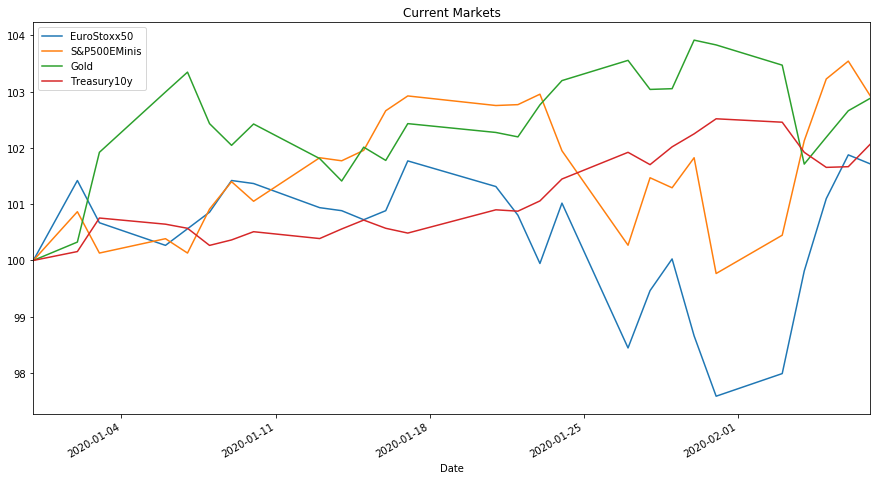

In [471]:
futures_index = (futures_new/futures_new.iloc[0])*100
futures_index.plot(figsize = (15,8),title="Current Markets");

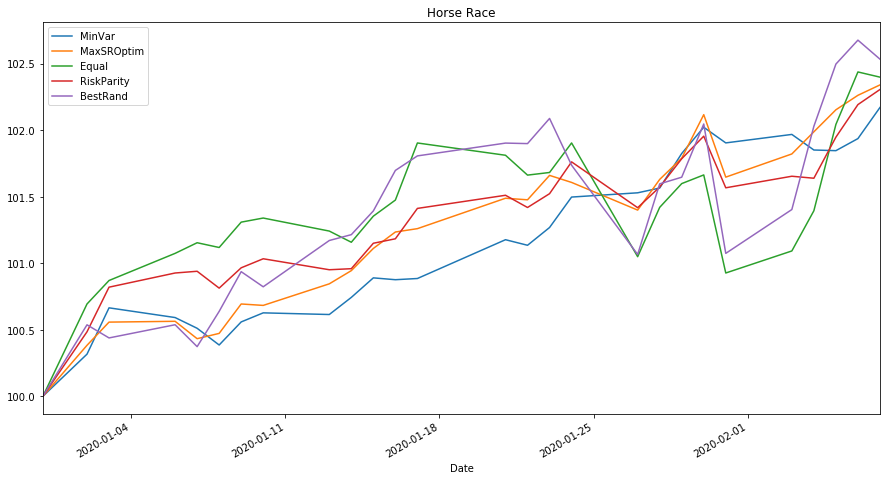

In [472]:
horse_race_df = pd.DataFrame(columns = port_df.index.tolist())
for method in port_df.index.tolist():
    horse_race_df.loc[:][method] = (futures_index*new_port_df.loc[method][0:4]).sum(axis=1)

horse_race_df.plot(figsize = (15,8),title="Horse Race");

In [473]:
horse_race_ports_df = port_df.copy(deep=True)
horse_race_ports_df = horse_race_ports_df.drop("Port_Std",axis=1)
horse_race_ports_df = horse_race_ports_df.drop("Port_Ret",axis=1)


for method in port_df.index.tolist():
    horse_race_ports_df.at[method,"Annual_Vol"] = horse_race_df[:][method].std()*(252**0.5)
    horse_race_ports_df.at[method,"Annual_Ret"] = (((float(horse_race_df[method].tail(1))/100)**(252/days_since_start))-1)*100
    horse_race_ports_df.at[method,"YTD_Ret"] = ((float(horse_race_df[method].tail(1))/100)-1)*100

horse_race_ports_df["Sharpe"] = horse_race_ports_df["Annual_Ret"]/horse_race_ports_df["Annual_Vol"]
horse_race_ports_df

,EuroStoxx50,S&P500EMinis,Gold,Treasury10y,Sharpe,Annual_Vol,Annual_Ret,YTD_Ret
MinVar,0.047,0.138,0.000,0.814,2.211,10.032,22.186,2.170
MaxSROptim,0.000,0.317,0.000,0.683,2.324,10.368,24.094,2.340
Equal,0.250,0.250,0.250,0.250,3.016,8.209,24.757,2.398
RiskParity,0.136,0.179,0.161,0.524,2.847,8.325,23.704,2.305
BestRand,0.000,0.531,0.013,0.456,2.322,11.326,26.304,2.534


The horse race has begun. Five Portfolios based on historic data now compete.

Current Issue: I use daily data that is logged for my optimizations and my matrix algebra to compute Volatility and Return figures. However, I use the realized volatility and returns computed from the time series which are quaterly rebalanced for my portfolio comparison that is ongoing below. Hence the two will be different.